# BFS Performance Comparison (Local vs Parallel)

Inspect BFS latencies collected from the local and parallel benchmark runs stored in `benchmark_local.json` and `benchmark_parallel_run0.json`. The notebook focuses on the BFS-only measurements and contrasts their behavior over time and by start vertex.


In [1]:
from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

plt.style.use("ggplot")
pd.set_option("display.max_rows", 20)
pd.options.display.float_format = "{:.3f}".format


/home/parshan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [10]:
DATA_ROOT = Path("/home/parshan/tinygraph")
LOCAL_PATH = DATA_ROOT / "benchmark_local_0.json"
PARALLEL_PATH = DATA_ROOT / "benchmark_parallel_run0.json"


def load_bfs_measurements(path: Path, label: str):
    """Load BFS-only records while preserving config + summary metadata."""
    with path.open() as f:
        payload = json.load(f)

    measurements = payload.get("measurements", [])
    if not measurements:
        raise ValueError(f"No measurements found in {path}")

    df = pd.DataFrame(measurements)
    bfs_df = df[df["operation"] == "bfs"].copy()
    if bfs_df.empty:
        raise ValueError(f"No BFS entries present in {path}")

    bfs_df["dataset"] = label
    bfs_df["timestamp"] = pd.to_datetime(bfs_df["timestamp"], utc=True)
    bfs_df["rtt_ms"] = bfs_df["rtt_ms"].astype(float)
    bfs_df["checkpoint"] = bfs_df["checkpoint"].astype(int)
    bfs_df = bfs_df.sort_values(["checkpoint", "timestamp"]).reset_index(drop=True)

    return bfs_df, payload.get("config", {}), payload.get("summary", {})


In [3]:
local_bfs, local_cfg, local_summary = load_bfs_measurements(LOCAL_PATH, "local")
parallel_bfs, parallel_cfg, parallel_summary = load_bfs_measurements(PARALLEL_PATH, "parallel")

bfs_df = pd.concat([local_bfs, parallel_bfs], ignore_index=True)

print("Loaded BFS samples:")
display(
    bfs_df.groupby("dataset")["checkpoint"].agg(["count", "min", "max"])
)

bfs_df.head()


Loaded BFS samples:


,count,min,max
dataset,,,
local,179,1,50
parallel,179,1,50


,operation,rtt_ns,rtt_ms,checkpoint,bfs_start,bfs_radius,timestamp,dataset,vertex_from,vertex_to
0,bfs,7970595,7.971,1,512,10.000,2025-11-25 07:01:31.228249099+00:00,local,NaN,NaN
1,bfs,259036992,259.037,2,983,10.000,2025-11-25 07:01:31.496956634+00:00,local,NaN,NaN
2,bfs,61503837,61.504,2,512,10.000,2025-11-25 07:01:31.558463491+00:00,local,NaN,NaN
3,bfs,1034062613,1034.063,3,983,10.000,2025-11-25 07:01:32.602767385+00:00,local,NaN,NaN
4,bfs,89616195,89.616,3,512,10.000,2025-11-25 07:01:32.692388520+00:00,local,NaN,NaN


In [4]:
def summarize_dataset(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.groupby("dataset")["rtt_ms"]
        .agg([
            ("count", "count"),
            ("mean_ms", "mean"),
            ("median_ms", "median"),
            ("std_ms", "std"),
            ("min_ms", "min"),
            ("max_ms", "max"),
        ])
        .sort_values("mean_ms")
    )

summary = summarize_dataset(bfs_df)
display(summary)

print("Local summary block:")
display(local_summary)
print("\nParallel summary block:")
display(parallel_summary)


,count,mean_ms,median_ms,std_ms,min_ms,max_ms
dataset,,,,,,
parallel,179,4254.390,4491.943,1486.496,1.696,6692.516
local,179,24663.059,21230.488,22221.355,7.971,85693.248


Local summary block:


{'total_operations': 291015,
 'total_add_vertices': 0,
 'total_add_edges': 291015,
 'total_bfs_queries': 179,
 'avg_rtt_ms': 24663.059121,
 'min_rtt_ms': 7.970595,
 'max_rtt_ms': 85693.248251,
 'total_duration_ns': 4415288546565,
 'total_duration_ms': 4415288.546565}


Parallel summary block:


{'total_operations': 308694,
 'total_add_vertices': 17500,
 'total_add_edges': 291015,
 'total_bfs_queries': 179,
 'avg_rtt_ms': 3.179221,
 'min_rtt_ms': 0.309889,
 'max_rtt_ms': 6692.5155,
 'total_duration_ns': 994455744384,
 'total_duration_ms': 994455.744384}

In [5]:
bfs_by_start = (
    bfs_df.groupby(["dataset", "bfs_start"])["rtt_ms"]
    .agg(["count", "mean", "median", "min", "max"])
    .rename(columns={"mean": "mean_ms", "median": "median_ms", "min": "min_ms", "max": "max_ms"})
)
display(bfs_by_start)


count   mean_ms  median_ms   min_ms    max_ms
dataset  bfs_start                                               
local    11282         21 23621.298  26588.947 2742.337 39067.437
         11702         19   973.732    796.741  407.440  2051.771
         512           50 16926.875  18712.361    7.971 37189.835
         5880          40 27685.717  23127.322   62.959 76648.336
         983           49 39721.775  40239.647  259.037 85693.248
parallel 11282         21  5282.935   5181.232 4358.315  6656.371
         11702         19  5369.374   5239.049 4487.198  6569.840
         512           50  3749.850   3924.584    1.696  6692.516
         5880          40  4345.790   4360.898 2418.671  6670.390
         983           49  3821.468   3935.448  520.124  6526.985

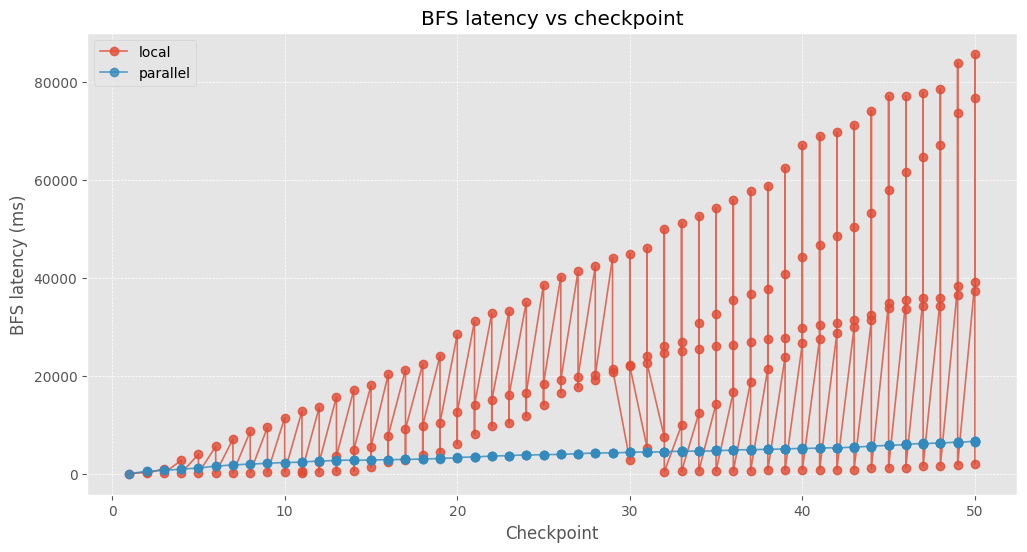

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
for label, group in bfs_df.groupby("dataset"):
    ax.plot(group["checkpoint"], group["rtt_ms"], marker="o", linewidth=1.2, alpha=0.8, label=label)

ax.set_xlabel("Checkpoint")
ax.set_ylabel("BFS latency (ms)")
ax.set_title("BFS latency vs checkpoint")
ax.legend()
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


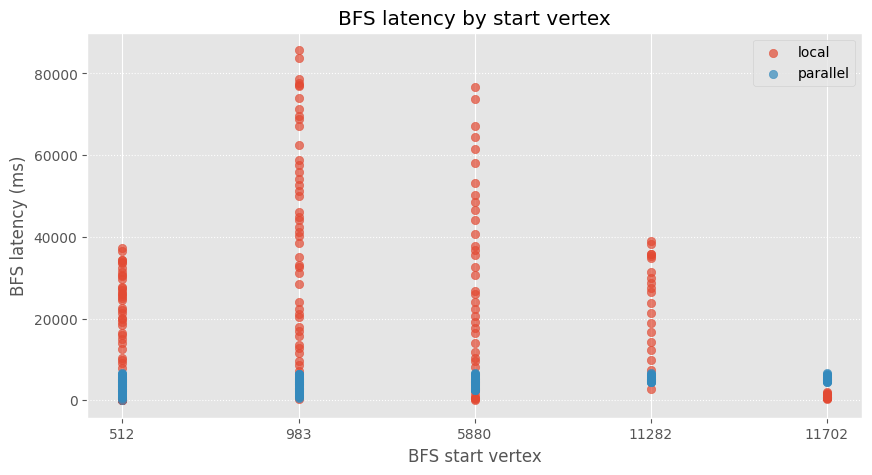

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
for label, group in bfs_df.groupby("dataset"):
    ax.scatter(group["bfs_start"], group["rtt_ms"], alpha=0.7, label=label)

ax.set_xlabel("BFS start vertex")
ax.set_ylabel("BFS latency (ms)")
ax.set_title("BFS latency by start vertex")
ax.legend()
ax.grid(axis="y", linestyle=":")
plt.show()


In [8]:
checkpoint_comparison = (
    bfs_df.pivot_table(index="checkpoint", columns="dataset", values="rtt_ms")
    .rename(columns={"local": "local_ms", "parallel": "parallel_ms"})
)
checkpoint_comparison["parallel_vs_local_pct"] = (
    (checkpoint_comparison["parallel_ms"] - checkpoint_comparison["local_ms"]) / checkpoint_comparison["local_ms"]
) * 100
checkpoint_comparison.head()


dataset,local_ms,parallel_ms,parallel_vs_local_pct
checkpoint,,,
1,7.971,1.696,-78.717
2,160.270,510.763,218.688
3,561.839,686.053,22.108
4,1433.902,936.884,-34.662
5,2058.749,1168.932,-43.221


In [9]:
pct_stats = checkpoint_comparison["parallel_vs_local_pct"].describe().to_frame(name="pct_diff")
display(pct_stats)


,pct_diff
count,50.000
mean,-67.034
std,45.548
min,-86.307
25%,-84.540
50%,-81.085
75%,-63.793
max,218.688


## Next steps
- Repeat with additional parallel runs (e.g., `benchmark_parallel_run*.json`) to validate consistency.
- Experiment with different `bfs_radius` values to see how sensitivity changes across datasets.
- Overlay shard/worker level metrics once available to pinpoint hotspots contributing to higher latencies.
